In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [2]:
# Merge transactions with product data
transactions = transactions.groupby(['CustomerID', 'ProductID']).agg(
    total_spent=('TotalValue', 'sum'),
    total_quantity=('Quantity', 'sum')
).reset_index()

# Pivot the data to create a customer-product matrix
customer_profile = transactions.pivot_table(
    index='CustomerID',
    columns='ProductID',
    values='total_spent',
    aggfunc='sum',
    fill_value=0
)

# Merge the aggregated transaction data with customer demographic data
customer_profile = customer_profile.merge(customers[['CustomerID', 'Region']], on='CustomerID')

In [3]:
# Normalize transaction data using StandardScaler
scaler = StandardScaler()
transaction_data = customer_profile.drop(['CustomerID', 'Region'], axis=1)
transaction_data_scaled = pd.DataFrame(scaler.fit_transform(transaction_data), columns=transaction_data.columns)

# Combine the scaled transaction data with the region data
customer_features = pd.concat([customer_profile[['CustomerID', 'Region']], transaction_data_scaled], axis=1)

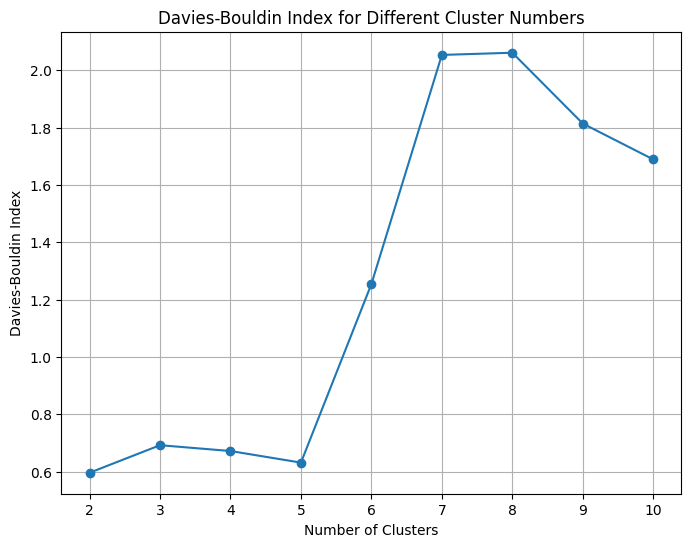

In [4]:
# Define a range of cluster numbers (between 2 and 10)
cluster_range = range(2, 11)

# Store Davies-Bouldin scores for each cluster number
db_scores = []

# Perform clustering for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(['CustomerID', 'Region'], axis=1))
    
    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_features.drop(['CustomerID', 'Region'], axis=1), customer_features['Cluster'])
    db_scores.append(db_index)

# Plot the Davies-Bouldin Index for different cluster numbers
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (let's assume it's 4 based on the plot)
optimal_clusters = 4

In [5]:
# Apply KMeans clustering with optimal clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(['CustomerID', 'Region'], axis=1))

# Add cluster labels back to the customer profile data
customer_profile['Cluster'] = customer_features['Cluster']

# Inspect the clustering result
print(customer_profile[['CustomerID', 'Cluster']].head())

  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        1
4      C0005        2


In [6]:
# Calculate the Davies-Bouldin Index for the final clustering
final_db_index = davies_bouldin_score(customer_features.drop(['CustomerID', 'Region'], axis=1), customer_features['Cluster'])
print(f'Davies-Bouldin Index: {final_db_index}')

Davies-Bouldin Index: 3.656937127185679


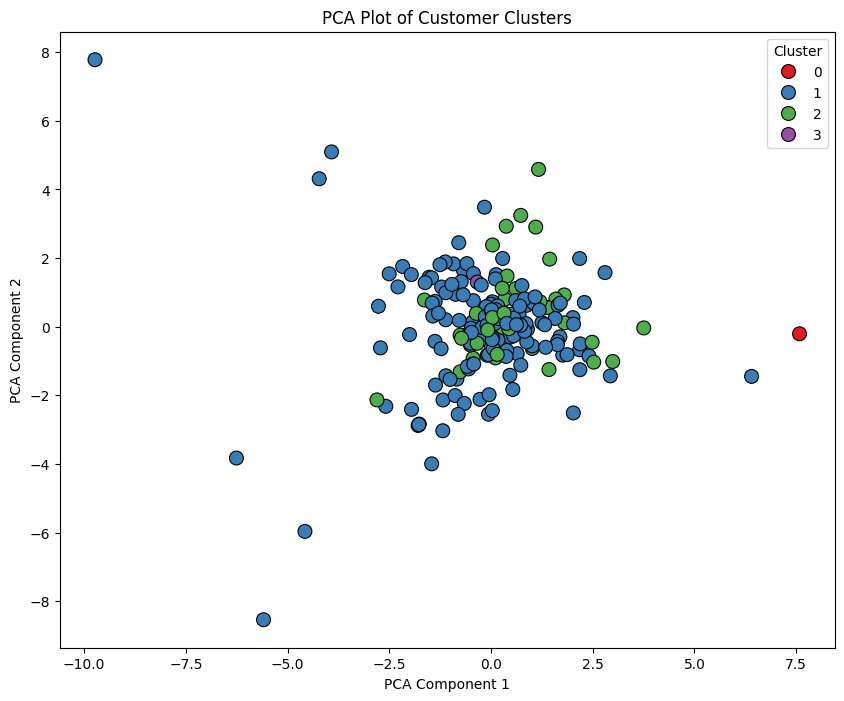

In [7]:
# Apply PCA to reduce the dimensions to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_features.drop(['CustomerID', 'Region'], axis=1))

# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_features['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, edgecolor='black')
plt.title('PCA Plot of Customer Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()